In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap

/Users/nathanchen/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Random Forest

In [ ]:
from ucimlrepo import fetch_ucirepo #lowkey this wasn't working for me so I 
# downloaded the data and loaded it manually. had to add columns too


colnames = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points",
] + \
[ f"Wilderness_Area{i}" for i in range(1, 5) ] + \
[ f"Soil_Type{i}" for i in range(1, 41) ] + \
["Cover_Type"]

covertype = pd.read_csv("/Users/nathanchen/Downloads/covertype/covtype.data.gz",
                        header=None,
                        names = colnames)

# data (as pandas dataframes) 
X = covertype.drop(columns=['Cover_Type'])
y = covertype[['Cover_Type']]

In [ ]:
# split the train and test data with test size 20%. Set the random state to ensure reproducibility.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025)

In [ ]:
model = RandomForestClassifier(n_estimators=10, 
                               criterion= 'gini',  
                               verbose=3,
                               random_state = 2025)
model.fit(X_train.values, y_train.values)

# this model has 10 estimators with gini criterion. the model is fit using the training data.
# this model is using all the available features.

/Users/nathanchen/miniforge3/lib/python3.12/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [ ]:
# The training data has more accuracy than the testing data. 
# This indicates that the model may be overfitting the training data and 
# not generalizing as well as it could to unseen data, however the accuracy for
# the testing data is very high, at 94% accurate. Therefore, we are not too worried
# about overfitting having a large negative effect on our predictive accuracy.

y_pred_train = model.predict(X_train.values)
y_pred_test = model.predict(X_test.values)
# calculate accuracy
train_acc = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_acc)

test_acc = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_acc)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


Training Accuracy: 0.9978012473940909
Testing Accuracy: 0.9447088285156149


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


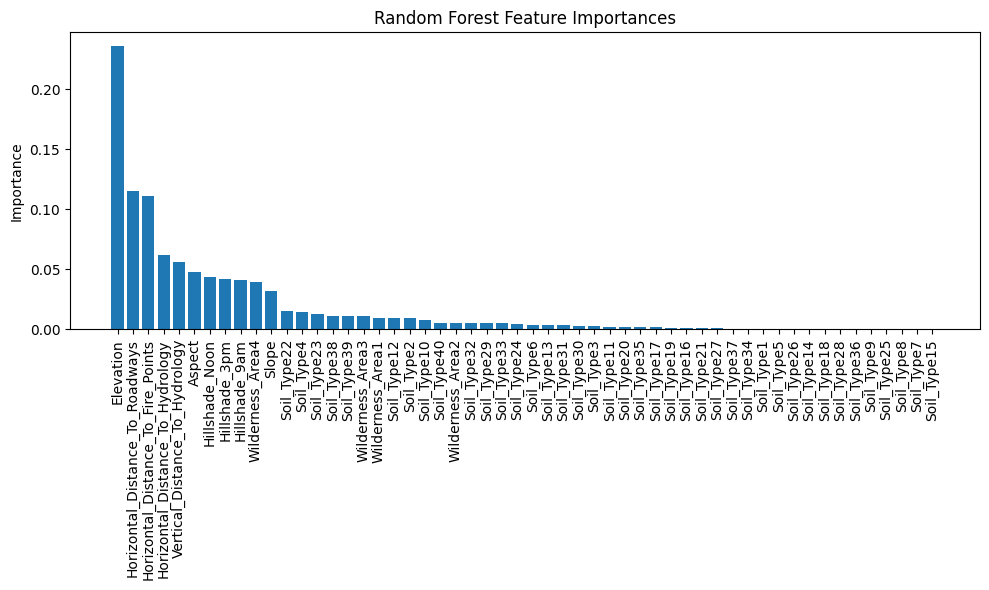

In [ ]:
# This plot shows the feature importances for our initial model.
# We see that the soil type variables, per our guess in EDA, are the least important features.
# The most important features appear to be Elevation, 
# Horizontal Distance to Hydrology, and Vertical Distance to Hydrology.
# We can use this information to create a more efficient model that removes soil type features.

importances = model.feature_importances_
feature_names = X.columns

# Sort in descending order
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), feature_names[idx], rotation=90)
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

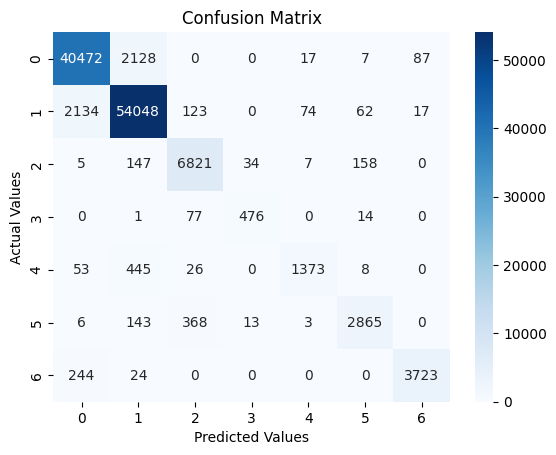

In [ ]:
# Here is our confusion matrix for our testing data predictions vs the actual data.
# We see that a majority of values are being predicted correctly,
# with very high values along the diagonal. We are seeing high misclassifications for
# data points between cover type 0 and 1. This is related to the high number of data points
# in these two classes, which may be causing the model to misclassify them more often.
# other misclassifications include actual class 4 being predicted as class 1, and 
# actual class 5 being predicted as class 2.

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test))

#here, we can see that the precision, reecall, and f1-scores
#are all very high across all classes, indicating strong model performance.
#the model is weakest at predicting class 5, with an f1-score of 0.81,
#with the lowest precision score of 0.91 with class 4 and the lowest recall
#score with class 5 at 0.72.
# we can see that the generally, the model is predicting well,
# with accuracy at 94% and weighted average f1-score of 0.94.

              precision    recall  f1-score   support

           1       0.94      0.95      0.95     42711
           2       0.95      0.96      0.95     56458
           3       0.92      0.95      0.94      7172
           4       0.91      0.84      0.87       568
           5       0.93      0.72      0.81      1905
           6       0.92      0.84      0.88      3398
           7       0.97      0.93      0.95      3991

    accuracy                           0.94    116203
   macro avg       0.94      0.88      0.91    116203
weighted avg       0.94      0.94      0.94    116203



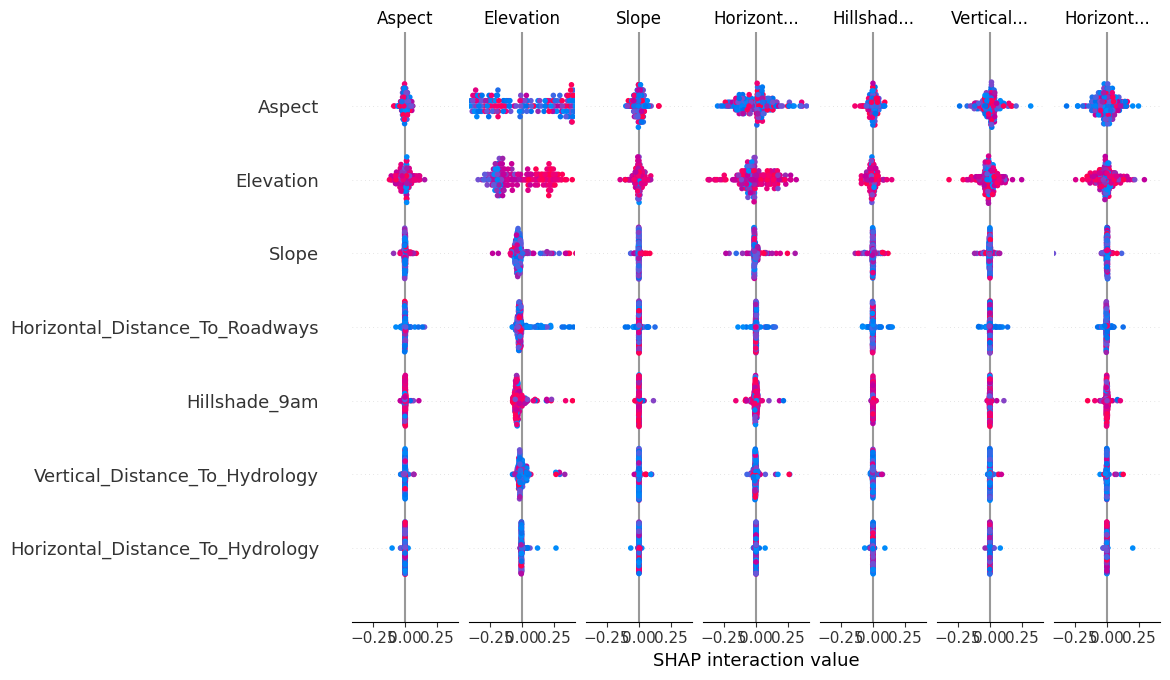

In [ ]:
background = shap.sample(X_train, 200, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, background)

#lowkey this is chatgpt spitting it out to me. I actually don't really know what this is but... okay...
#maybe confirm with gemini and claude before taking this as truth


#this plot shows how pairs of features impact the random forest predictions. 
# a wide spread of points along the x-axis per feature pair means that
#there is important interaction between the variables, while a narrow spread 
# means that there is little to no interaction.
# Additionally, red points indicate higher feature values, while blue points indicate lower feature values.
# A farther distance from zero means stronger interactions between the features.

# We can see that elevation and horizontal_distance_to_roadways have a strong interaction.
# Specifically, since the blue values are clustered closer to the center and the red values farther away,
# we know that low elevation values do not strongly interact with horizontal distance to roadways. 
# We can also see that elevation and aspect have the strongest interactions overall.


## Removing soil type variables

In [ ]:
# because soils are not important features, we can drop them and create a new model.

soils = [f"Soil_Type{i}" for i in range(1, 41)]
X_subset = X.drop(columns = soils)

In [16]:
X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(X_subset, 
                                                                  y, 
                                                                  test_size = 0.2, 
                                                                  random_state = 2025)

In [ ]:
model_subset = RandomForestClassifier(n_estimators=10, 
                               criterion= 'gini',  
                               verbose=3,
                               random_state = 2025)
model_subset.fit(X_subset_train.values, y_subset_train.values)

# again, the model is using 10 estimators with gini criterion and 
# the random state is set for reproducibility.

building tree 1 of 10


/Users/nathanchen/miniforge3/lib/python3.12/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [ ]:
y_subset_pred_train = model_subset.predict(X_subset_train.values)
y_subset_pred_test = model_subset.predict(X_subset_test.values)
# calculate accuracy
train_acc = accuracy_score(y_subset_train, y_subset_pred_train)
print("Training Accuracy:", train_acc)

test_acc = accuracy_score(y_subset_test, y_subset_pred_test)
print("Testing Accuracy:", test_acc)

# Again, we see that training accuracy is higher than testing accuracy,
# but the testing accuracy is very high at 0.94. Thus, removing the soil features
# did not significantly impact model predictions and make them less accurate.

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


Training Accuracy: 0.9977453104393418
Testing Accuracy: 0.9386848876535029


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


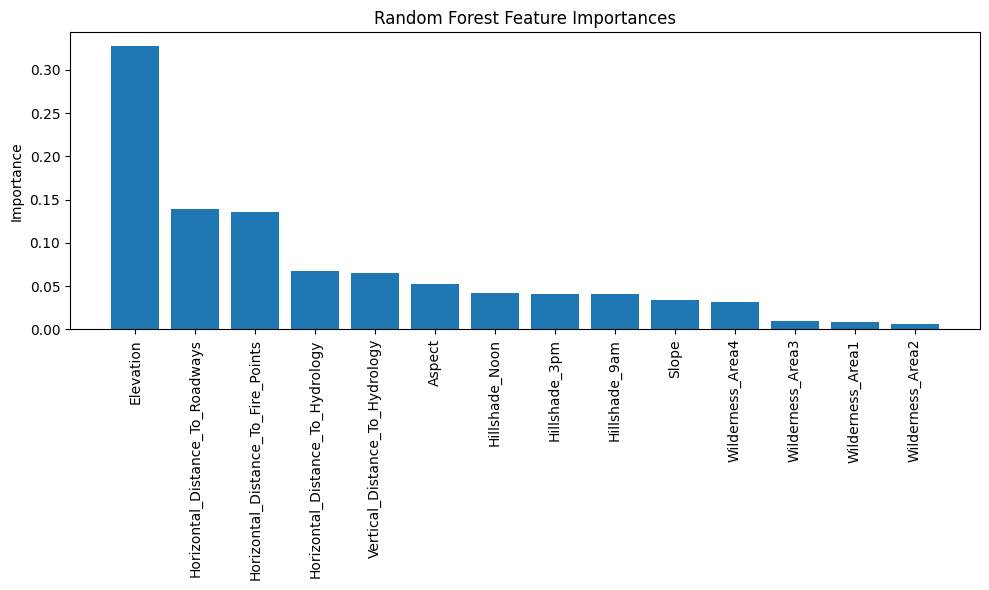

In [ ]:
#here are the feature importances for the new model without soil features.
#We can see that the strongest predictors are still elevation, horizontal distance to roadways,
# and horizontal distance to fire points. The weakest predictors are the wildnerness area one-hot
# encoded variables, along with slope.

importances = model_subset.feature_importances_
feature_names = X_subset.columns

# Sort in descending order
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), feature_names[idx], rotation=90)
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

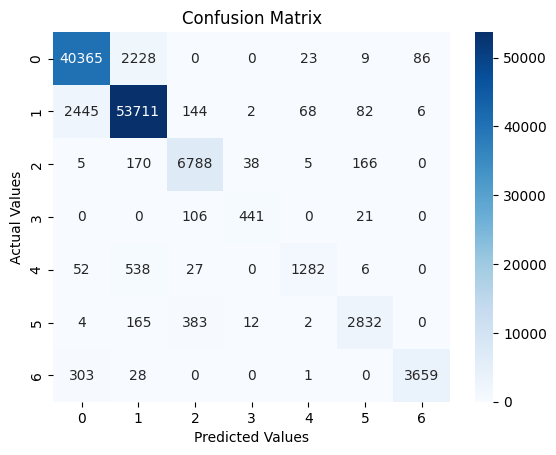

In [ ]:
# we see the same pattern in this confusion matrix as the original model.
# the diagonal values are the highest, which means that the model is good at prediction.
# The most commonly misclassified tree cover types are 0 and 1. Next most misclassified
# are the actual value 4 being classified as 1 and the actual value 5 being classified as 2.

cm = confusion_matrix(y_subset_test, y_subset_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

In [ ]:
print(classification_report(y_subset_test, y_subset_pred_test))

# in this classification report, we see that the evaluation metrics are 
# still pretty good, even with the soil types removed. The lowest precision score
# is tied between class 3 and class 6, while the lowest recall score is still class 5.
# The lowest f1-score is still class 5. The accuracy and weighted average f1-score have not decreased
# significantly, which means that the model is still predicting well.

              precision    recall  f1-score   support

           1       0.93      0.95      0.94     42711
           2       0.94      0.95      0.95     56458
           3       0.91      0.95      0.93      7172
           4       0.89      0.78      0.83       568
           5       0.93      0.67      0.78      1905
           6       0.91      0.83      0.87      3398
           7       0.98      0.92      0.95      3991

    accuracy                           0.94    116203
   macro avg       0.93      0.86      0.89    116203
weighted avg       0.94      0.94      0.94    116203



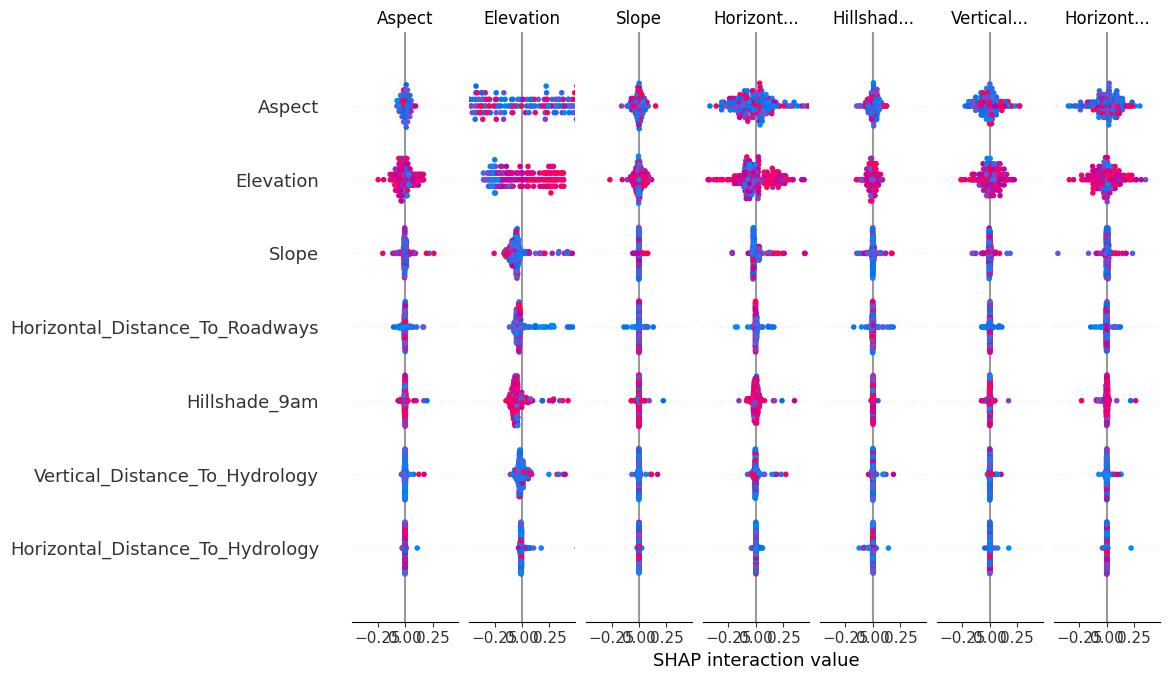

In [ ]:
background = shap.sample(X_subset_train, 200, random_state=42)
explainer = shap.TreeExplainer(model_subset)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, background)

# this plot shows a similar pattern to the previous SHAP summary plot.
# Elevation and aspect have strong interactions with most other variables.


In [ ]:
model_subset_large = RandomForestClassifier(n_estimators=100, 
                               criterion= 'gini',  
                               verbose=3,
                               random_state = 2025)
model_subset_large.fit(X_subset_train.values, y_subset_train.values)

#here, we are testing if the model improves with more estimators.
# this model uses 100 estimators.

/Users/nathanchen/miniforge3/lib/python3.12/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   20.0s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [ ]:
y_subset_large_pred_train = model_subset_large.predict(X_subset_train.values)
y_subset_large_pred_test = model_subset_large.predict(X_subset_test.values)
# calculate accuracy
train_acc = accuracy_score(y_subset_train, y_subset_large_pred_train)
print("Training Accuracy:", train_acc)

test_acc = accuracy_score(y_subset_test, y_subset_large_pred_test)
print("Testing Accuracy:", test_acc)

print(classification_report(y_subset_test, y_subset_large_pred_test))

# as we can see from the training and testing accuracies, the model did not improve
# significantly with more estimators. The accuracies are nearly identical to the previous model.
# The accuracy is less than a percent higher for both training and testing data.
# However, the classification report shows that the precision, recall, and f1-scores
# have improved significantly across the classes. Specifically, the lowest precision, recall, and f1-scores
# have improved over the previous model, with a 0.04 increase in f1-score for class 5 and a 0.05 increase 
# in recall score for class 5.
# The accuracy and weighted average f1-score are pretty similar from the previous model.
# Therefore, we can conclude that the model with only 10 estimators is the best for our needs,
# since the predictive power is pretty similar but the model is faster to train and much more 
# computationally efficient to use.

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.6s


Training Accuracy: 1.0
Testing Accuracy: 0.9521957264442398
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42711
           2       0.95      0.97      0.96     56458
           3       0.93      0.96      0.95      7172
           4       0.89      0.82      0.86       568
           5       0.95      0.72      0.82      1905
           6       0.93      0.89      0.91      3398
           7       0.98      0.94      0.96      3991

    accuracy                           0.95    116203
   macro avg       0.94      0.89      0.91    116203
weighted avg       0.95      0.95      0.95    116203



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


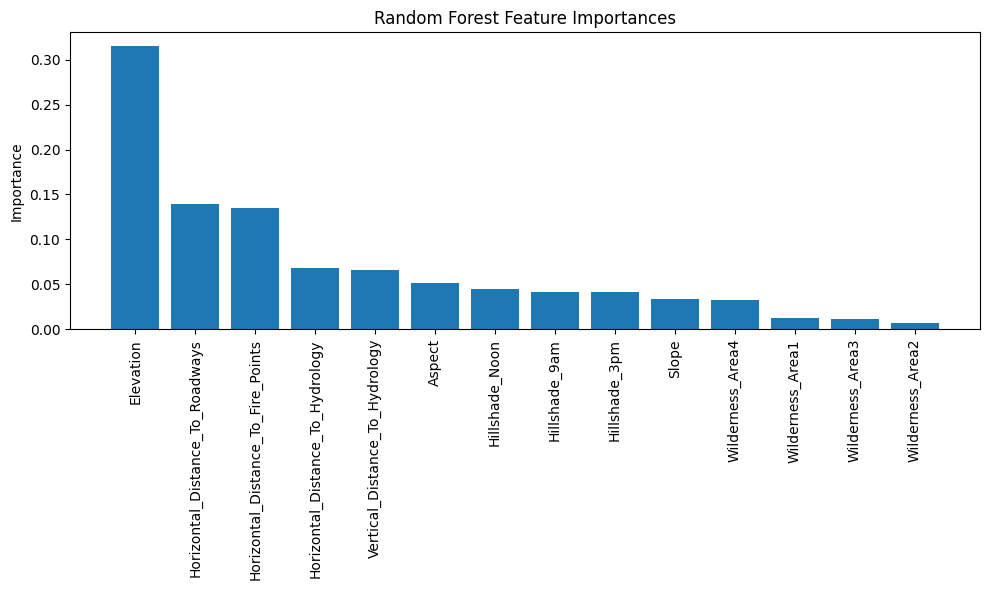

In [ ]:
importances = model_subset_large.feature_importances_
feature_names = X_subset.columns

# Sort in descending order
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), feature_names[idx], rotation=90)
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# The feature importances are the same as the previous model with 10 estimators.
# The most important features are still elevation, horizontal distance to roadways,
# and horizontal distance to fire points. The least important features are still
# the wilderness area one-hot encoded variables.

# CODE BELOW IS FROM CHECK-IN. NOT RELEVANT FOR PROJECT CODE.
# Check-in week 5/6

We are predicting what the wilderness area is (type Rawah (area 1) or Comanche Peak (area 3)) from cartographic variables.

In [8]:
mask = (X["Wilderness_Area1"] == 1) | (X["Wilderness_Area3"] == 1)
subset = X[mask]
subset = subset[["Elevation", "Aspect", "Slope",
                  "Horizontal_Distance_To_Hydrology",	"Vertical_Distance_To_Hydrology",
                  "Horizontal_Distance_To_Roadways",	"Hillshade_9am", "Hillshade_Noon",
                  "Hillshade_3pm",	"Horizontal_Distance_To_Fire_Points",
                  "Wilderness_Area1"]]
display(subset.head())

print(subset.shape)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1
0,2596,51,3,258,0,510,221,232,148,6279,1
1,2590,56,2,212,-6,390,220,235,151,6225,1
2,2804,139,9,268,65,3180,234,238,135,6121,1
3,2785,155,18,242,118,3090,238,238,122,6211,1
4,2595,45,2,153,-1,391,220,234,150,6172,1


(514160, 11)


<Axes: ylabel='Count'>

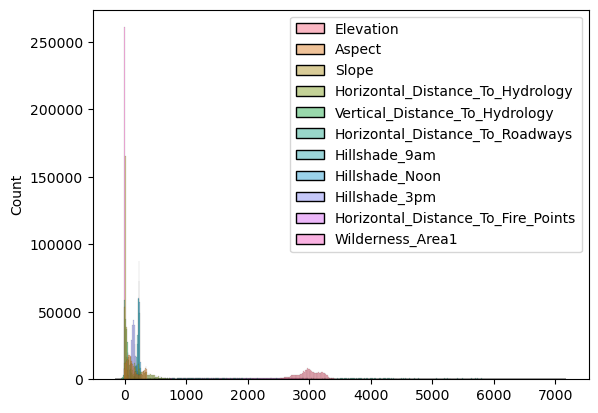

In [9]:
sns.histplot(subset[subset["Wilderness_Area1"] == 1])

In [4]:
subset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1
0,2596,51,3,258,0,510,221,232,148,6279,1
1,2590,56,2,212,-6,390,220,235,151,6225,1
2,2804,139,9,268,65,3180,234,238,135,6121,1
3,2785,155,18,242,118,3090,238,238,122,6211,1
4,2595,45,2,153,-1,391,220,234,150,6172,1


In [5]:
# prepare Random Forest predictors and response
X_rf = subset[["Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Fire_Points", "Horizontal_Distance_To_Roadways"]]
y_rf = subset[["Wilderness_Area1"]]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size = 0.2)

In [ ]:
# Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train, criterion = 'gini')

# predictions
y_probs_train = model.predict_proba(X_train)[:, 1]
y_preds_train = (y_probs_train >= 0.5).astype(int)

y_probs_test = model.predict_proba(X_test)[:, 1]
y_preds_test = (y_probs_test >= 0.5).astype(int)

# calculate accuracy
train_acc = accuracy_score(y_train, y_preds_train)
print("Training Accuracy:", train_acc)

test_acc = accuracy_score(y_test, y_preds_test)
print("Testing Accuracy:", test_acc)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Accuracy: 0.9998128014625798
Testing Accuracy: 0.810311965147036


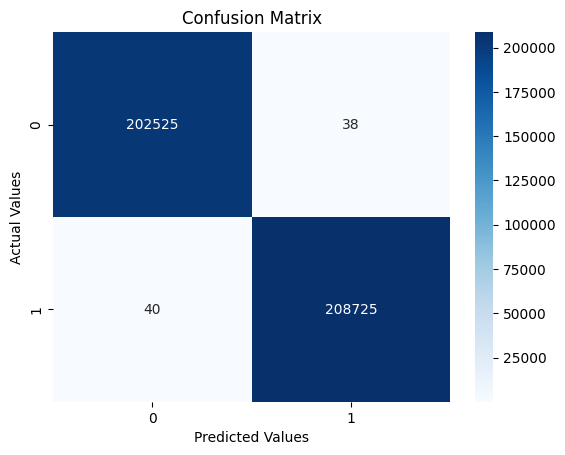

Prediction Accuracy: 0.9998103703127431
Prediction Error: 0.000189629687256887
True Positive Rate: 0.9998083970014131
F1 Score: 0.9998131861815256


In [ ]:
# confusion matrix, prediction accuracy, prediction error, true positive rate, true negative rate, F1 score of training set

# confusion matrix
cm = confusion_matrix(y_train, y_preds_train)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

# prediction accuracy
acc = accuracy_score(y_train, y_preds_train)
print("Prediction Accuracy:", acc)

# prediction error
error = 1 - acc
print("Prediction Error:", error)

# true positive rate
tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print("True Positive Rate:", tpr)

# F1 score
f1 = f1_score(y_train, y_preds_train)
print("F1 Score:", f1)

The model has good diagnostics. The confusion matrix shows that there are very few errors, and the accuracy, true positive rate, and F1 score are all very high (close to 1).

AUC: 0.9004479326503931


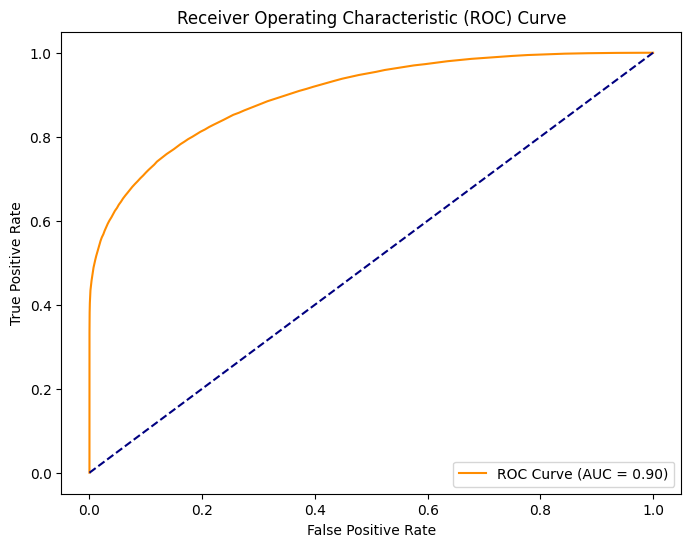

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)
roc_auc = roc_auc_score(y_test, y_probs_test)

print("AUC:", roc_auc)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


explanation

our roc curve does have a high accuracy alongside with our confusion matrix but that is mainly because the tree dataset itself is designed to be overfitted. The testing accuracy and the cross-validation results do end up being around 0.80 which is much more accurate for our random forest model on unseen data because our feature selection using vertical distance to hydrology, and horizontal distance to fires/roadways. We still have a 0.80 testing accuracy though which means our model performs well for new test data.

In [ ]:
# 5-fold cross-validation on the test set
cv_results = cross_validate(model, X_test, y_test, cv=5,
                            scoring=['accuracy', 'roc_auc'])

print("Cross-validation results (Accuracy):", cv_results['test_accuracy'])
print("Cross-validation results (AUC):", cv_results['test_roc_auc'])

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Cross-validation results (Accuracy): [0.79160792 0.79997083 0.7965088  0.7940776  0.79704366]
Cross-validation results (AUC): [0.88179835 0.8840094  0.88280242 0.8808761  0.88439966]
